# Computer Vision(CV) Challenge

This is a flower classification probelm on famous Oxform 102flower data.

**Table of Context**

1. Download Dataset
2. Extract Dataset and arrange it
3. Image visulisation and observation
4. Loading data and resizeing images
5. Data Augmenation Layer
6. load model ResNet50 (prefer pytorch)
<br>6.1 Trasfer learning using Finetuning method
<br>6.2 Trasfer learning using Feature extraction method

In [1]:
! pip install keras_cv
import os
import time
import tarfile
import keras_cv
import shutil
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
import requests
from tqdm import tqdm
from scipy.io import loadmat
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 35.1 MB/s eta 0:00:00


## 1. Downloading Dataset

In [2]:
dataset_images_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
image_label_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'
data_split_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat'
class_names_url = 'https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt'
urls = [
    dataset_images_url,
    image_label_url,
    data_split_url,
    class_names_url
]

In [3]:
def download_file(url: str):
    '''
    Download file from url and store it in current directory.
    '''
    file_name = f"{url.split('/')[-1]}"
    try:
        t0 = time.time()
        response = requests.get(url)
        if response.status_code != 200:
            raise
        with open(f"raw_data/{file_name}", 'wb') as file:
            file.write(response.content)
        return file_name, time.time() - t0
    except Exception as e:
        print(f"Issue downloading file: {file_name}\n Exception: {e}")

def download_parallel(args: list[str]):
    '''
    Download urls in parallel
    '''
    if not os.path.isdir('raw_data'):
        os.mkdir('raw_data')
    cpus = cpu_count()
    results = ThreadPool(cpus - 1).imap_unordered(download_file, args)
    for (file, time_taken) in results:
        print(f"file: {file}, time_taken: {time_taken: .2f}s")

In [4]:
download_parallel(urls)

file: 102flowers.tgz, time_taken:  31.86s
file: imagelabels.mat, time_taken:  1.19s
file: setid.mat, time_taken:  1.25s
file: Oxford-102_Flower_dataset_labels.txt, time_taken:  0.29s


## 2. Extract Files and arrange it


In [5]:
# Unzip files
try:
    for file in os.listdir('raw_data'):
        if '.tgz' in file:
            file_path = f"raw_data/{file}"
            f = tarfile.open(file_path)
            f.extractall(f'raw_data/{file.split(".")[0]}')


except FileNotFoundError as e:
    print(f"File not found: \n{e}")

In [6]:
# Extract lable data
labels = loadmat('raw_data/imagelabels.mat')
class_names = {}
with open('raw_data/Oxford-102_Flower_dataset_labels.txt', 'r') as f:
    for i,line in enumerate(f):
        class_names[i+1] = line.strip().replace("'", "")
labels = labels['labels'].reshape(-1)

df = pd.DataFrame({
    "label": labels,
    "file": [f'image_{i:05d}.jpg' for i in range(1, labels.shape[0] + 1)]
})

df['class_name'] = df['label'].apply(lambda x: class_names[x])

# height and width
width = []
height = []

for label, file in zip(df['label'], df['file']):
    img = Image.open(f"raw_data/102flowers/jpg/{file}")
    curr_width, curr_height = img.size
    width.append(curr_width)
    height.append(curr_height)

df['width'] = pd.Series(width)
df['height'] = pd.Series(height)
df.head()

label             file      class_name  width  height
0     77  image_00001.jpg  passion flower    591     500
1     77  image_00002.jpg  passion flower    625     500
2     77  image_00003.jpg  passion flower    500     667
3     77  image_00004.jpg  passion flower    667     500
4     77  image_00005.jpg  passion flower    508     500

In [7]:
df.label.min()

np.uint8(1)

In [8]:
# Extract train test and validation separation info
setid = loadmat('raw_data/setid.mat')

print(setid['trnid'].shape)
print(setid['valid'].shape)
print(setid['tstid'].shape)

# converting from 1-based indexing to zero-based indexing
train_ids = setid['tstid'][0] - 1
test_ids = setid['trnid'][0] - 1
val_ids = setid['valid'][0] - 1

(1, 1020)
(1, 1020)
(1, 6149)


Arrange image files in following format in train, test and validation folder:
```
train/
    /1
        /image001.jpg
    /2
    ...
    102/
```


In [9]:
# Arange data data in for
def arrange(src_path: str, des_path: str, partition: pd.DataFrame):
    if not os.path.isdir(des_path):
        os.mkdir(des_path)
    for label, file in tqdm(zip(partition['label'], partition['file'])):
        src_file_path = f"{src_path}/{file}"
        des_dir_path = f"{des_path}/{label}"
        if not os.path.isdir(des_dir_path):
            os.mkdir(des_dir_path)
        try:
            shutil.copy(src_file_path, des_dir_path, follow_symlinks=False)
        except Exception as e:
            print(f"Error copying file {file} \nException: {e}")


In [10]:
arrange("raw_data/102flowers/jpg", "train", df.iloc[train_ids, :])
arrange("raw_data/102flowers/jpg", "validation", df.iloc[val_ids, :])
arrange("raw_data/102flowers/jpg", "test", df.iloc[test_ids, :])

6149it [00:03, 1971.07it/s]
1020it [00:00, 1984.67it/s]
1020it [00:00, 2261.31it/s]


## 3. Image visulisation and observation

- The images of different width and height
- The example for each flower class is unequal.
- Quantity of example per class is between 40-200. We need atleast 200 image for every class

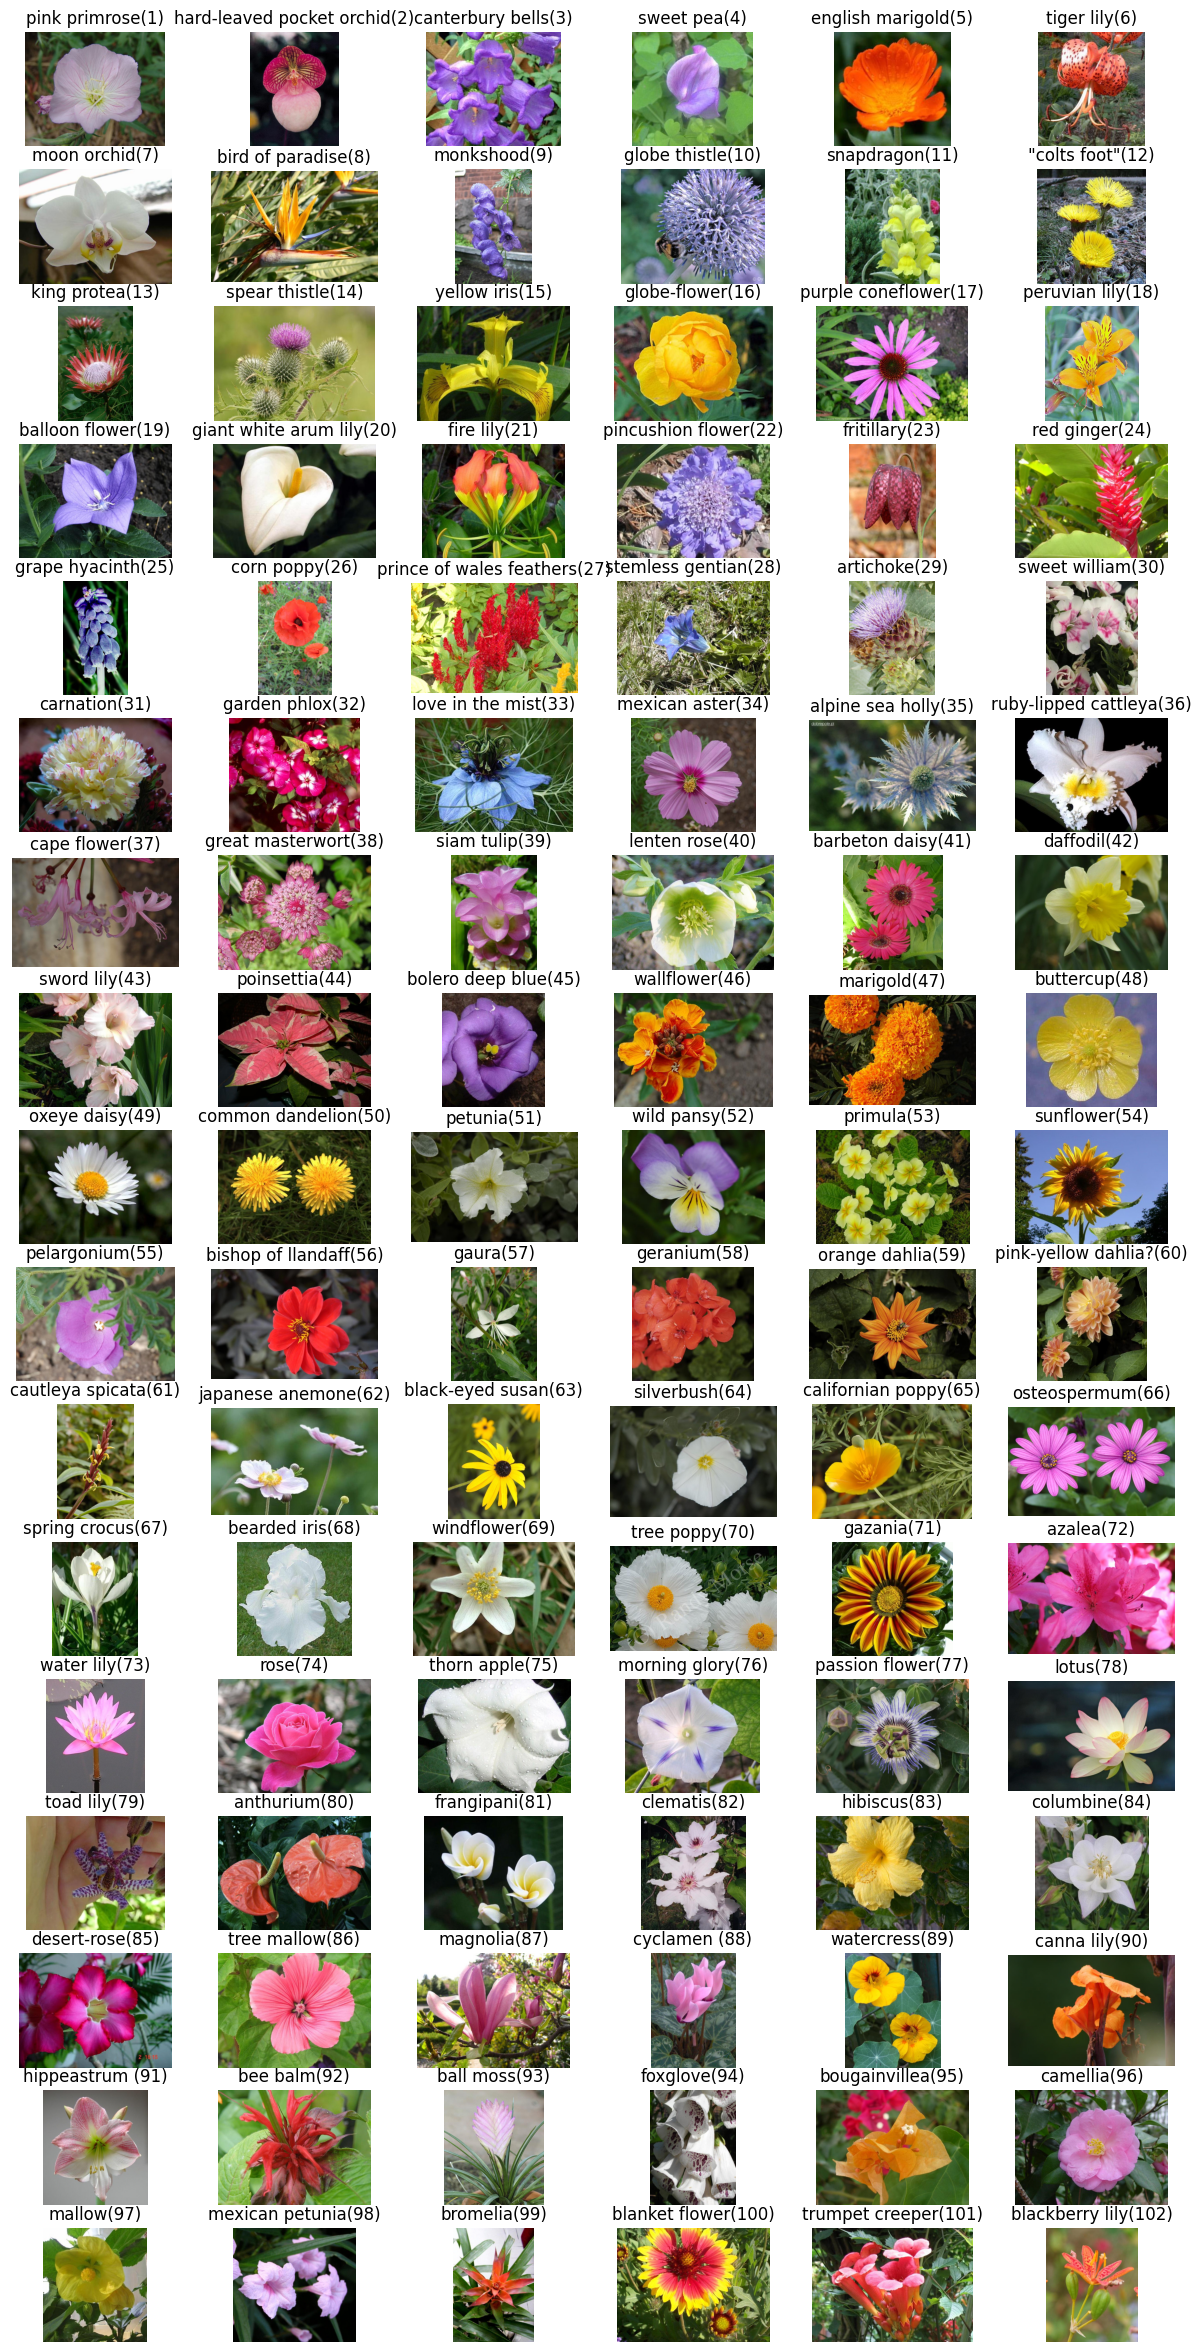

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
images_path = 'train'


fig, ax = plt.subplots(17, 6, figsize=(15, 30))
for i,category in enumerate(sorted(os.listdir(images_path), key=lambda x: int(x))):
    category_path = f"{images_path}/{category}"
    img_path = f"{category_path}/{os.listdir(category_path)[0]}"
    img = Image.open(img_path)
    ax.flat[i].imshow(img)
    ax.flat[i].axis('off')
    ax.flat[i].set_title(f"{class_names[i+1]}({i+1})")



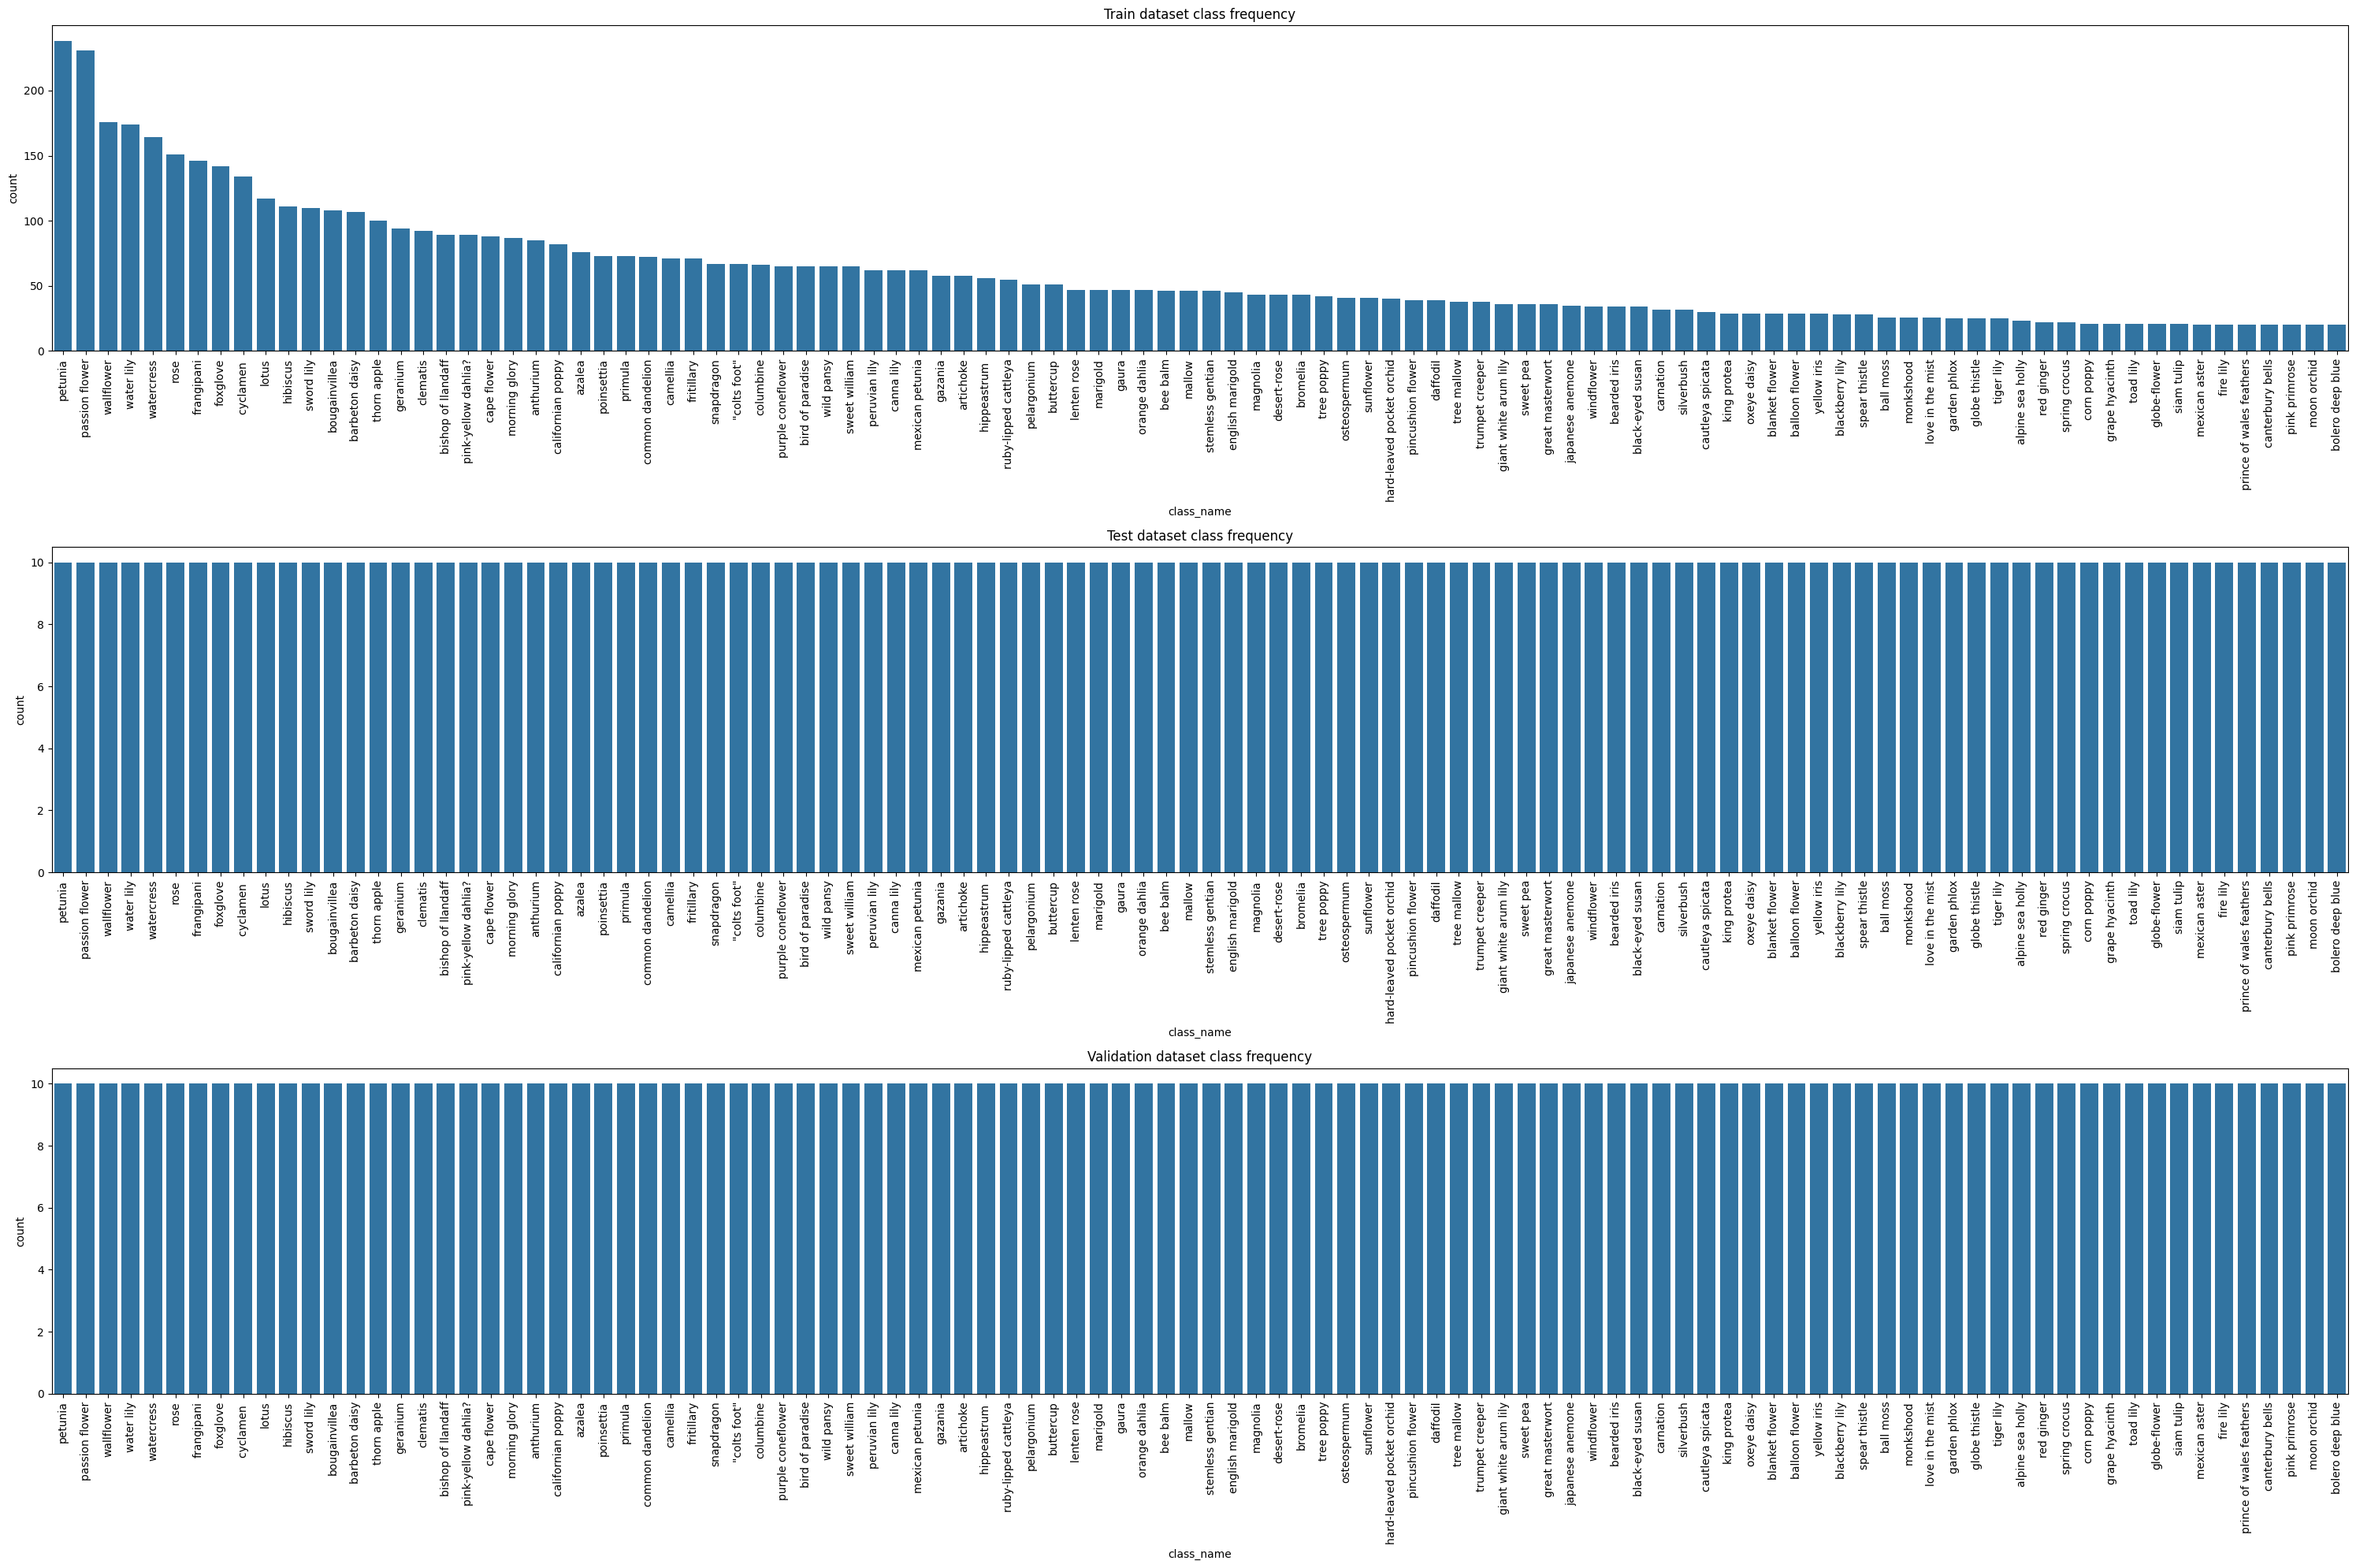

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(30, 20))

sns.countplot(data=df.iloc[train_ids, :], x='class_name', ax=ax.flat[0], order = df['class_name'].value_counts().index)
ax.flat[0].tick_params(axis='x', labelrotation=90)
ax.flat[0].set_title("Train dataset class frequency")
# plt.show()

sns.countplot(data=df.iloc[test_ids, :], x='class_name', ax=ax.flat[1], order = df['class_name'].value_counts().index)
ax.flat[1].tick_params(axis='x', labelrotation=90)
ax.flat[1].set_title("Test dataset class frequency")
# plt.show()

sns.countplot(data=df.iloc[val_ids, :], x='class_name', ax=ax.flat[2], order = df['class_name'].value_counts().index)
ax.flat[2].tick_params(axis='x', labelrotation=90)
ax.flat[2].set_title("Validation dataset class frequency")
plt.tight_layout()
plt.title("Validation dataset class frequency")
plt.show()

Text(0.5, 0, 'Height')

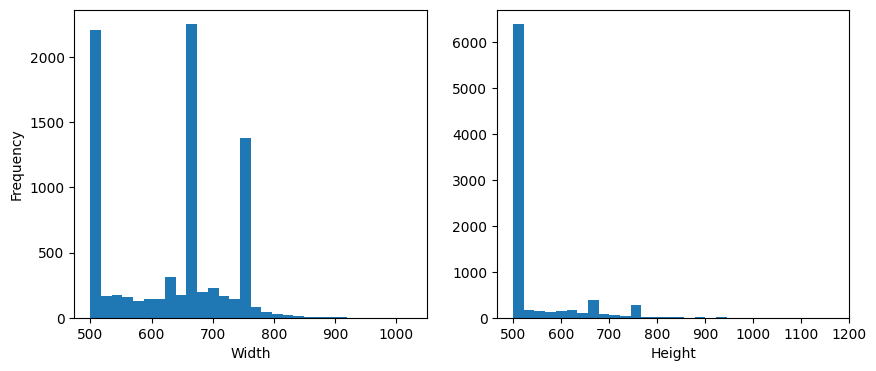

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax.flat[0].hist(df['width'], bins=30)
ax.flat[0].set_xlabel("Width")
ax.flat[0].set_ylabel("Frequency")
ax.flat[1].hist(df['height'], bins=30)
ax.flat[1].set_xlabel("Height")

## 4. Loading data and resizing images

- All images resized to highest size of image taken by ResNet50 i.e **224 x 224**

In [14]:
# Loading images
BATCH_SIZE = 32
IMG_SIZE=(224, 224)
COLOR_MODE='rgb'
train_ds = tf.keras.utils.image_dataset_from_directory(
    "train",
    seed=123,
    image_size=IMG_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "validation",
    seed=123,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "test",
    seed=123,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 6149 files belonging to 102 classes.
Found 1020 files belonging to 102 classes.
Found 1020 files belonging to 102 classes.


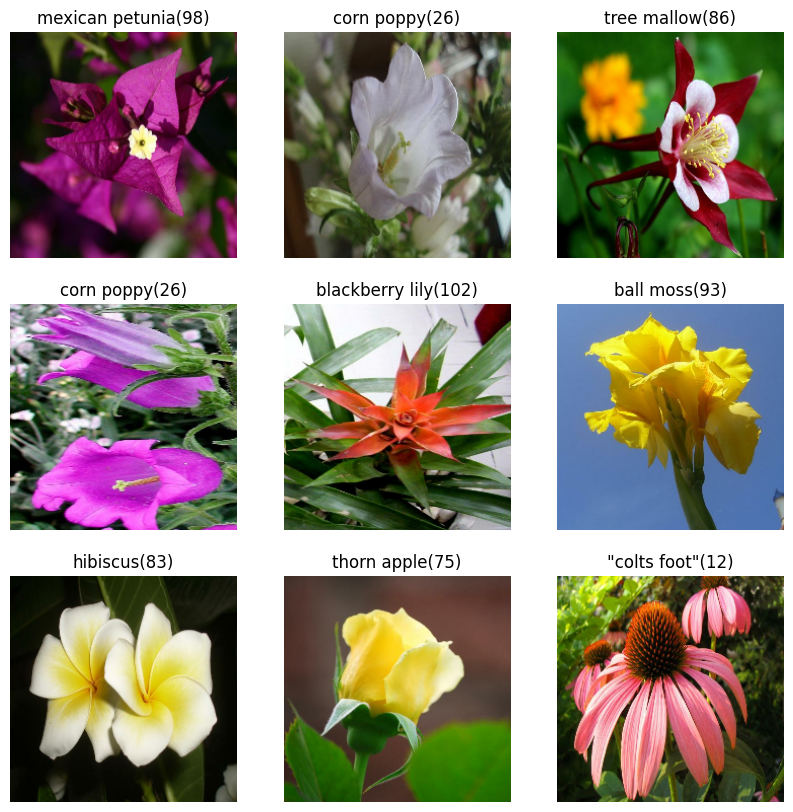

In [15]:
# Pictures after resizing the images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  labels = labels.numpy()
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy() / 255)
    plt.title(f"{class_names[labels[i]+1]}({labels[i]+1})")
    plt.axis("off")

## 5. Data Augmentation

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=123),
    tf.keras.layers.RandomRotation(0.5, seed=123),
    tf.keras.layers.RandomColorJitter(brightness_factor=0.2, contrast_factor=0.2, seed=123),
    tf.keras.layers.RandomZoom(0.1, seed=123),
    tf.keras.layers.RandomContrast(0.2, seed=123),
    keras_cv.layers.RandomCutout(
        height_factor=0.3,
        width_factor=0.3,
        fill_value=0.0
    )
])

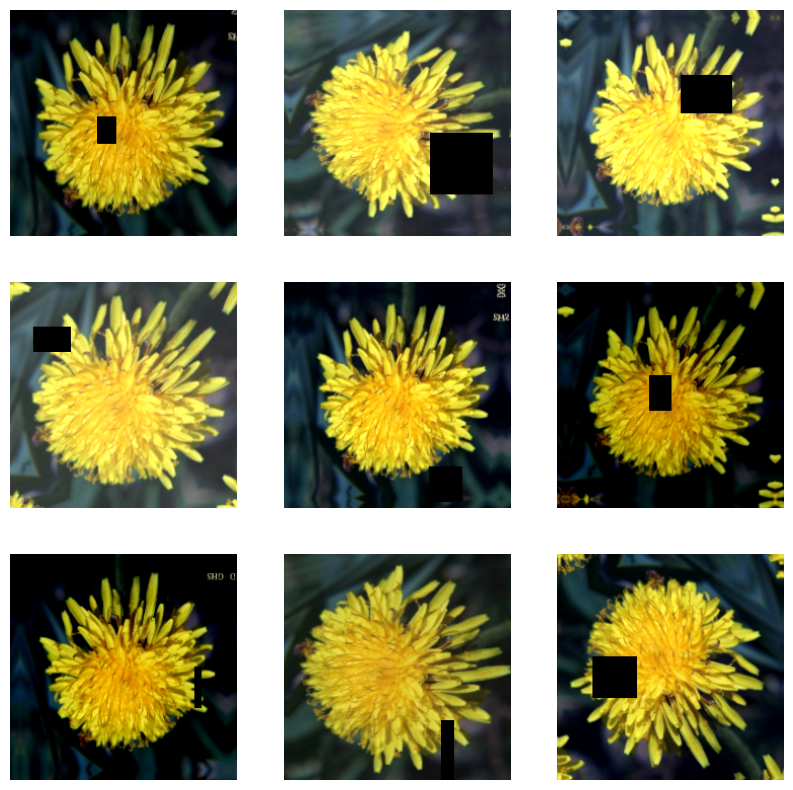

In [17]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## 6. Loading Model and transfer learning



In [18]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet'
)

base_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

### 6.1 Trasfer learning using Fine-tuning method

- This method involves unfreezing some top layers of the ResNet50 model and then finetune the model.
- Here I am unfreezing top 10 layers

In [19]:

print(f"No of layers in ResNet50: {len(base_model.layers)}")
base_model.trainable = True

for layer in base_model.layers[:171]:
    layer.trainable = False

base_model.summary()

No of layers in ResNet50: 175


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [20]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=IMG_SHAPE),
        data_augmentation,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(102, activation='softmax')
    ]
)
base_learning_rate = 0.0001

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 102)            │       208,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,796,710 (90.78 MB)

 Trainable params: 1,263,718 (4.82 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [21]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
)

Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 47s 171ms/step - loss: 3.2563 - sparse_categorical_accuracy: 0.3296 - val_loss: 1.2706 - val_sparse_categorical_accuracy: 0.6676
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - loss: 1.0987 - sparse_categorical_accuracy: 0.7053 - val_loss: 0.8921 - val_sparse_categorical_accuracy: 0.7657
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - loss: 0.8005 - sparse_categorical_accuracy: 0.7690 - val_loss: 0.7137 - val_sparse_categorical_accuracy: 0.8059
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.8191 - val_loss: 0.7476 - val_sparse_categorical_accuracy: 0.8059
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 42s 161ms/step - loss: 0.5721 - sparse_categorical_accuracy: 0.8385 - val_loss: 0.6498 - val_sparse_categorical_accuracy: 0.8343
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - loss: 0.5298 - sparse_categorical_accuracy: 0.8480 - val_loss: 0.6052 - val_sparse_categorical_acc

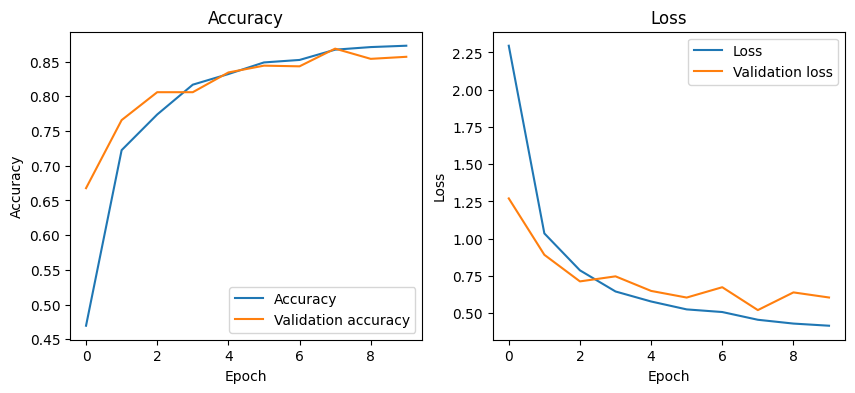

In [22]:
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']
accuracy = history.history['sparse_categorical_accuracy']
loss = history.history['loss']
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax.flat[0].plot(accuracy, label='Accuracy')
ax.flat[0].plot(val_accuracy, label='Validation accuracy')
ax.flat[0].set_xlabel("Epoch")
ax.flat[0].set_ylabel("Accuracy")
ax.flat[0].set_title("Accuracy")
ax.flat[0].legend()

ax.flat[1].plot(loss, label="Loss")
ax.flat[1].plot(val_loss, label="Validation loss")
ax.flat[1].set_xlabel("Epoch")
ax.flat[1].set_ylabel("Loss")
ax.flat[1].set_title("Loss")
ax.flat[1].legend()

plt.show()

In [23]:
model.evaluate(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 0.8427 - sparse_categorical_accuracy: 0.7992


[0.7265830636024475, 0.8235294222831726]

### Accuracy analysis

In [24]:
pred = model.predict(test_dataset)
pred.shape

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step


(1020, 102)

In [25]:
pred = pred.argmax(axis=1)
pred.shape

(1020,)

In [26]:
actual = np.concatenate([y for x, y in test_dataset], axis=0)
actual.shape

(1020,)

In [27]:
accuracy_matrix = pd.DataFrame({"actual": actual+1, "inaccurate_prediction": (actual != pred)})
accuracy_matrix

actual  inaccurate_prediction
0          1                  False
1          1                  False
2          1                  False
3          1                  False
4          1                  False
...      ...                    ...
1015     102                  False
1016     102                  False
1017     102                  False
1018     102                  False
1019     102                  False

[1020 rows x 2 columns]

In [28]:
res = accuracy_matrix.groupby('actual')['inaccurate_prediction'].sum().reset_index()
res['flower'] = pd.Series(class_names.values())
res = res.sort_values("inaccurate_prediction")
res.head()

actual  inaccurate_prediction                     flower
1        2                      0  hard-leaved pocket orchid
4        5                      0           english marigold
11      12                      0               "colts foot"
9       10                      0              globe thistle
14      15                      0                yellow iris

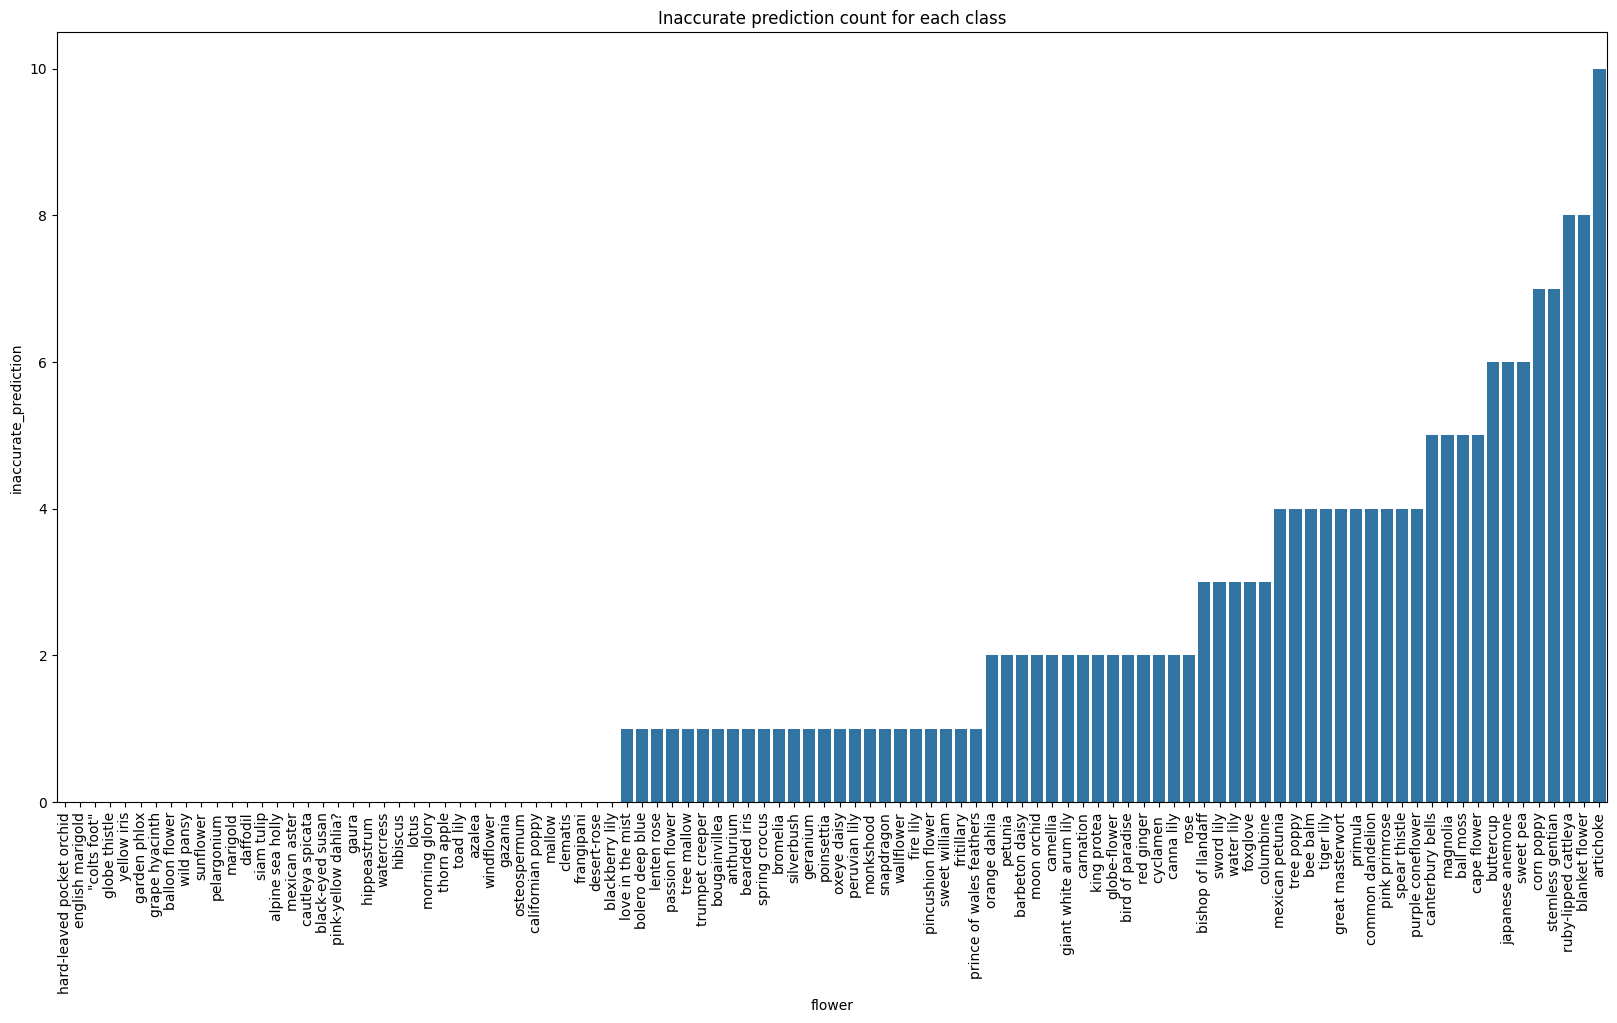

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=res, x="flower", y="inaccurate_prediction", ax=ax)
ax.set_title("Inaccurate prediction count for each class")
ax.tick_params(axis='x', labelrotation=90)

### 6.2 Trasfer learning using Feature Extraction method

- Here the whole model is freezed just top sigmoid layer is train during model training.
- So we take advantage of feature extraction capability of the pre-trained model.

In [30]:
base_model.trainable = False
input = tf.keras.layers.Input(shape=IMG_SHAPE)
x = data_augmentation(input)
x = base_model(x, training=False)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
x = global_average_layer(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
prediction_layer = tf.keras.layers.Dense(102, activation='softmax')
output = prediction_layer(x)

model = tf.keras.Model(input, output)
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │       208,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,804,902 (90.81 MB)

 Trainable params: 213,094 (832.40 KB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [31]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - loss: 2.5848 - sparse_categorical_accuracy: 0.4265 - val_loss: 0.9931 - val_sparse_categorical_accuracy: 0.7539
Epoch 2/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 37s 150ms/step - loss: 0.7485 - sparse_categorical_accuracy: 0.7934 - val_loss: 0.6863 - val_sparse_categorical_accuracy: 0.8196
Epoch 3/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - loss: 0.5159 - sparse_categorical_accuracy: 0.8585 - val_loss: 0.6256 - val_sparse_categorical_accuracy: 0.8422
Epoch 4/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - loss: 0.4536 - sparse_categorical_accuracy: 0.8743 - val_loss: 0.5866 - val_sparse_categorical_accuracy: 0.8412
Epoch 5/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - loss: 0.3792 - sparse_categorical_accuracy: 0.8918 - val_loss: 0.5526 - val_sparse_categorical_accuracy: 0.8578


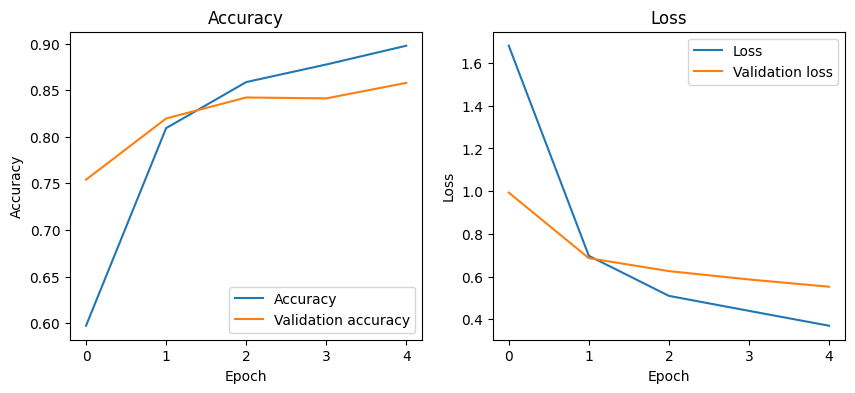

In [32]:
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']
accuracy = history.history['sparse_categorical_accuracy']
loss = history.history['loss']
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax.flat[0].plot(accuracy, label='Accuracy')
ax.flat[0].plot(val_accuracy, label='Validation accuracy')
ax.flat[0].set_xlabel("Epoch")
ax.flat[0].set_ylabel("Accuracy")
ax.flat[0].set_title("Accuracy")
ax.flat[0].legend()

ax.flat[1].plot(loss, label="Loss")
ax.flat[1].plot(val_loss, label="Validation loss")
ax.flat[1].set_xlabel("Epoch")
ax.flat[1].set_ylabel("Loss")
ax.flat[1].set_title("Loss")
ax.flat[1].legend()

plt.show()

In [41]:
model.evaluate(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 0.7230 - sparse_categorical_accuracy: 0.8212


[0.6298903822898865, 0.8401960730552673]

### Accuracy Analysis

In [33]:
model.evaluate(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.7668 - sparse_categorical_accuracy: 0.8104


[0.6610320806503296, 0.8294117450714111]

In [34]:
x = test_dataset.take(1)
x

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [35]:
pred = model.predict(test_dataset)
pred.shape

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step


(1020, 102)

In [36]:
pred = pred.argmax(axis=1)
pred.shape

(1020,)

In [37]:
actual = np.concatenate([y for x, y in test_dataset], axis=0)
actual.shape

(1020,)

In [38]:
accuracy_matrix = pd.DataFrame({"actual": actual+1, "inaccurate_prediction": (actual != pred)})
accuracy_matrix

actual  inaccurate_prediction
0          1                  False
1          1                  False
2          1                  False
3          1                  False
4          1                  False
...      ...                    ...
1015     102                  False
1016     102                  False
1017     102                  False
1018     102                  False
1019     102                  False

[1020 rows x 2 columns]

In [39]:
res = accuracy_matrix.groupby('actual')['inaccurate_prediction'].sum().reset_index()
res['flower'] = pd.Series(class_names.values())
res = res.sort_values("inaccurate_prediction")
res.head()

actual  inaccurate_prediction                     flower
1        2                      0  hard-leaved pocket orchid
4        5                      0           english marigold
7        8                      0           bird of paradise
9       10                      0              globe thistle
11      12                      0               "colts foot"

In [40]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=res, x="flower", y="inaccurate_prediction", ax=ax)
ax.set_title("Inaccurate prediction count for each class")
ax.tick_params(axis='x', labelrotation=90)



## Summary

I applied two transfer learning methods using ResNet50. First, fine-tuning a few top layers resulted in ~80% test accuracy. Second, using feature extraction (training only the final classification layer) achieved ~82% test accuracy. To improve generalization, data augmentation was applied to increase image diversity.

Accuracy analysis showed poor performance on classes with fewer images. This issue could potentially be addressed with oversampling techniques.